In [205]:
!rm -rf/content/*

rm: invalid option -- '/'
Try 'rm --help' for more information.


# **IMPORT LIBRARY**

In [206]:
!pip install kneed
!pip install mlxtend

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import LabelEncoder
from yellowbrick.cluster import KElbowVisualizer
import joblib
from sklearn.decomposition import PCA
from kneed import KneeLocator
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
from scipy.spatial import ConvexHull

# **LOAD DATASET**

In [208]:
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# **EDA AWAL**

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [210]:
df.shape

(541909, 8)

In [211]:
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,float64
Country,object


In [212]:
print("STATISTIK DESKRIPTIF")
df.describe()

STATISTIK DESKRIPTIF


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [213]:
print("JUMLAH NILAI HILANG PER KOLOM")
df.isnull().sum()

JUMLAH NILAI HILANG PER KOLOM


,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [214]:
print("JUMLAH DATA TERDUPLIKASI")
print(df.duplicated().sum())

JUMLAH DATA TERDUPLIKASI
5268


In [215]:
df['IsCancelled'] = df['InvoiceNo'].astype(str).str.contains('C')

print("JUMLAH TRANSAKSI CANCELLED")
print(df['IsCancelled'].sum())

JUMLAH TRANSAKSI CANCELLED
9288


In [216]:
print("CEK NILAI NEGATIF / 0")
print("Quantity ≤ 0 :", (df['Quantity'] <= 0).sum())
print("UnitPrice ≤ 0:", (df['UnitPrice'] <= 0).sum())

CEK NILAI NEGATIF / 0
Quantity ≤ 0 : 10624
UnitPrice ≤ 0: 2517


In [217]:
print("CUSTOMERID YANG KOSONG")
print(df['CustomerID'].isna().sum())

CUSTOMERID YANG KOSONG
135080


In [218]:
print("CONTOH TRANSAKSI BERMASALAH")
problem_rows = df[(df['Quantity'] <= 0) | (df['UnitPrice'] <= 0) | (df['IsCancelled'] == True)]
problem_rows.head()

CONTOH TRANSAKSI BERMASALAH


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,True


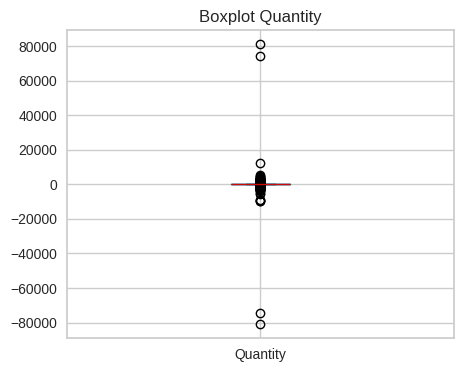

In [219]:
df['Quantity'].plot(kind='box', figsize=(5,4))
plt.title("Boxplot Quantity")
plt.show()

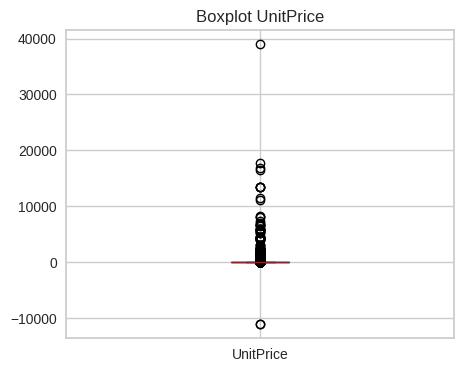

In [220]:
df['UnitPrice'].plot(kind='box', figsize=(5,4))
plt.title("Boxplot UnitPrice")
plt.show()

In [221]:
df['Country'].value_counts()

,count
Country,
United Kingdom,495478
Germany,9495
France,8557
EIRE,8196
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,2002
Portugal,1519


# **DATA CLEANING**

In [222]:
df_clean = df.drop_duplicates()

In [223]:
df_clean['IsCancelled'] = df_clean['InvoiceNo'].astype(str).str.contains('C')
df_clean = df_clean[df_clean['IsCancelled'] == False]
df_clean = df_clean.drop(columns=['IsCancelled'])

In [224]:
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

In [225]:
df_clean = df_clean[df_clean['CustomerID'].notna()]
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

In [226]:
Q_upper = df_clean['Quantity'].quantile(0.99)
U_upper = df_clean['UnitPrice'].quantile(0.99)

df_clean = df_clean[(df_clean['Quantity'] <= Q_upper) &
                    (df_clean['UnitPrice'] <= U_upper)]

In [227]:
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

In [228]:
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# **EDA FINAL**

In [229]:
df_clean.shape

(385081, 9)

In [230]:
df_clean.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
TotalPrice,0


In [231]:
df_clean.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
count,385081.00000,385081,385081.000000,385081.000000,385081.000000
mean,10.00891,2011-07-10 21:11:24.148581632,2.731160,15296.219393,17.909082
min,1.00000,2010-12-01 08:26:00,0.001000,12347.000000,0.001000
25%,2.00000,2011-04-07 11:16:00,1.250000,13969.000000,4.920000
50%,6.00000,2011-07-31 12:52:00,1.950000,15159.000000,11.700000
75%,12.00000,2011-10-20 13:20:00,3.750000,16794.000000,19.500000
max,120.00000,2011-12-09 12:50:00,14.950000,18287.000000,1314.000000
std,14.64235,NaN,2.545555,1709.581669,30.593204


In [232]:
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


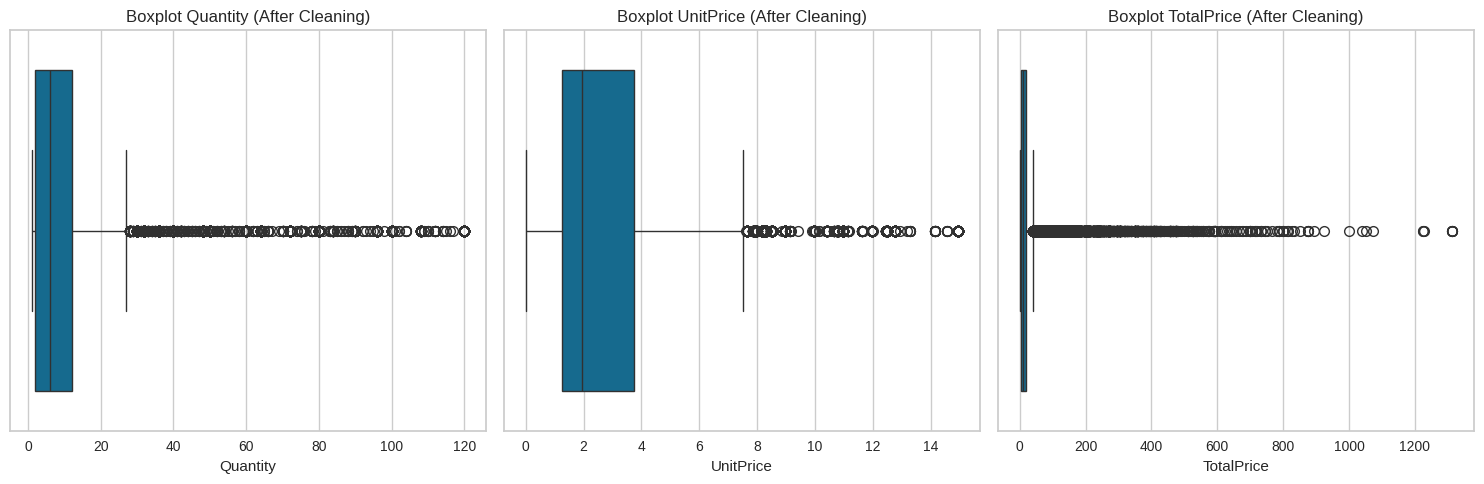

In [233]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=df_clean['Quantity'])
plt.title("Boxplot Quantity (After Cleaning)")

plt.subplot(1, 3, 2)
sns.boxplot(x=df_clean['UnitPrice'])
plt.title("Boxplot UnitPrice (After Cleaning)")

plt.subplot(1, 3, 3)
sns.boxplot(x=df_clean['TotalPrice'])
plt.title("Boxplot TotalPrice (After Cleaning)")

plt.tight_layout()
plt.show()

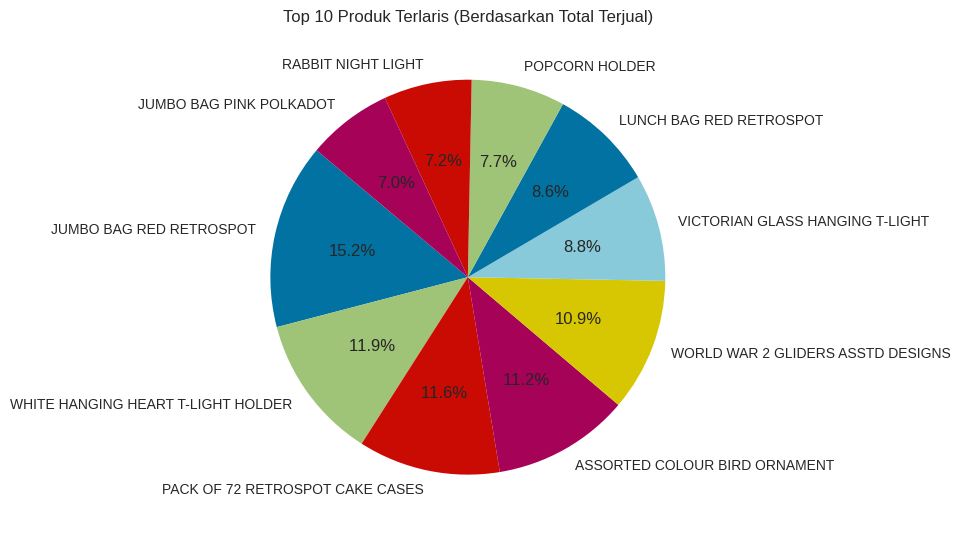

In [234]:
top_products = (
    df_clean.groupby('Description')['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure()
plt.pie(
    top_products,
    labels=top_products.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Top 10 Produk Terlaris (Berdasarkan Total Terjual)')
plt.tight_layout()
plt.show()

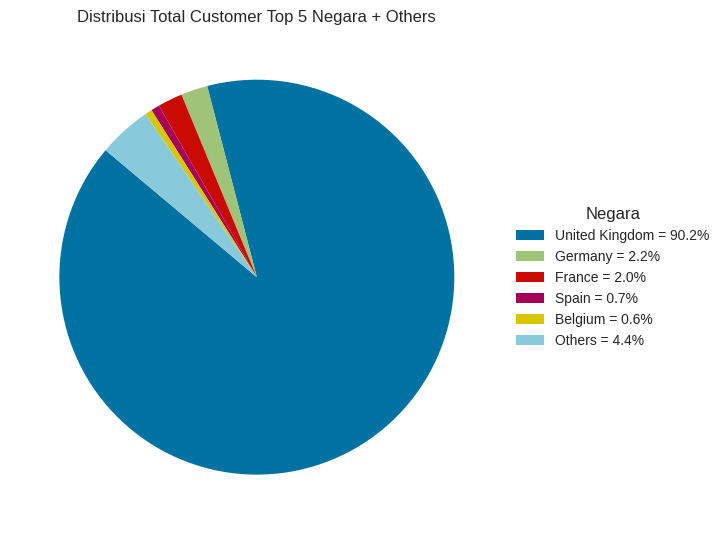

In [235]:
customer_per_country = (
    df_clean.groupby('Country')['CustomerID']
    .nunique()
    .sort_values(ascending=False)
)

top5 = customer_per_country.head(5)

others = customer_per_country.iloc[5:].sum()
top5['Others'] = others

percentages = (top5 / top5.sum()) * 100

plt.figure()

wedges, texts = plt.pie(
    top5.values,
    startangle=140
)

legend_labels = [
    f"{country} = {percent:.1f}%"
    for country, percent in zip(top5.index, percentages)
]

plt.legend(
    wedges,
    legend_labels,
    title="Negara",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.title('Distribusi Total Customer Top 5 Negara + Others')
plt.tight_layout()
plt.show()


dua diagram
- product pie chart (product| total barang yg terjual) 10 produk
- bar chart (negara | total customer)

UK 200000
US 10000

# **RFM**

In [236]:
snapshot_date = (df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)).normalize()
snapshot_date

Timestamp('2011-12-10 00:00:00')

In [237]:
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347,2,7,4060.40
12348,75,4,1186.68
12349,18,1,1353.80
12350,310,1,294.40
12352,36,7,1385.74


In [238]:
rfm.describe()

,Recency,Frequency,Monetary
count,4290.000000,4290.000000,4290.000000
mean,92.098834,4.191142,1607.563469
std,99.991422,7.465179,4815.340647
min,0.000000,1.000000,2.900000
25%,17.000000,1.000000,287.962500
50%,50.000000,2.000000,632.060000
75%,142.000000,5.000000,1540.470000
max,373.000000,205.000000,158967.800000


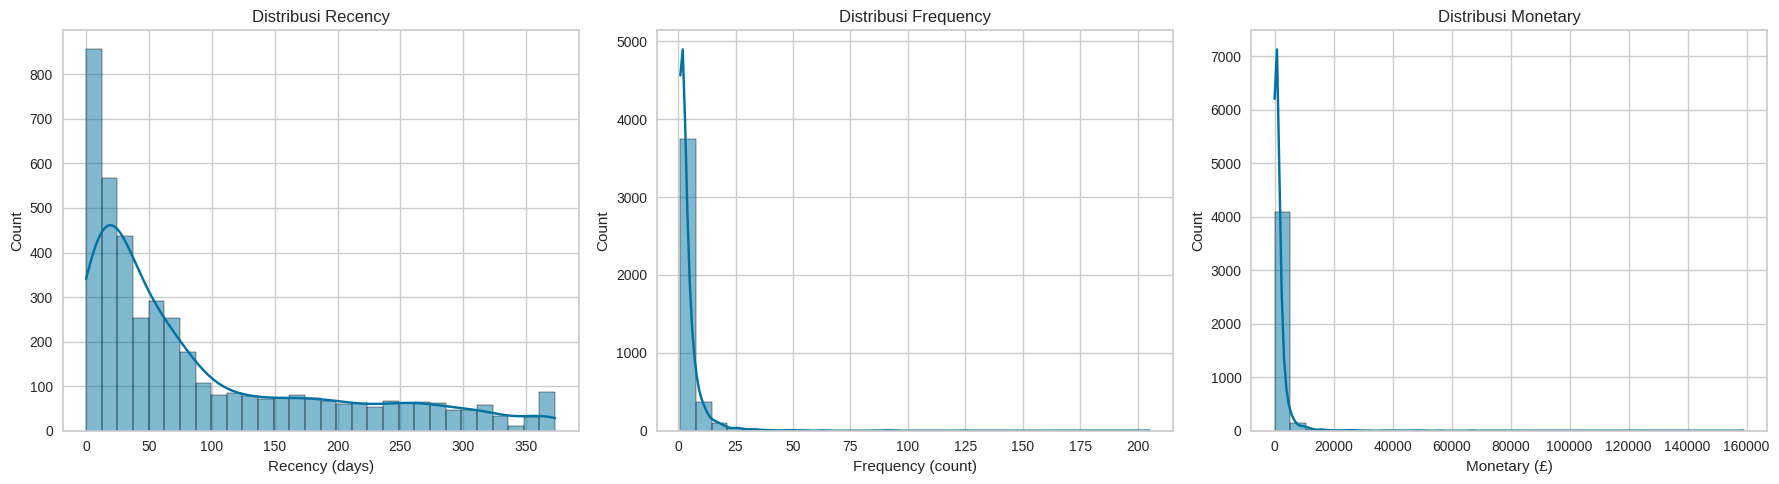

In [239]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=30, kde=True)
plt.title('Distribusi Recency')
plt.xlabel('Recency (days)')

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=30, kde=True)
plt.title('Distribusi Frequency')
plt.xlabel('Frequency (count)')

plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=30, kde=True)
plt.title('Distribusi Monetary')
plt.xlabel('Monetary (£)')

plt.tight_layout()
plt.show()

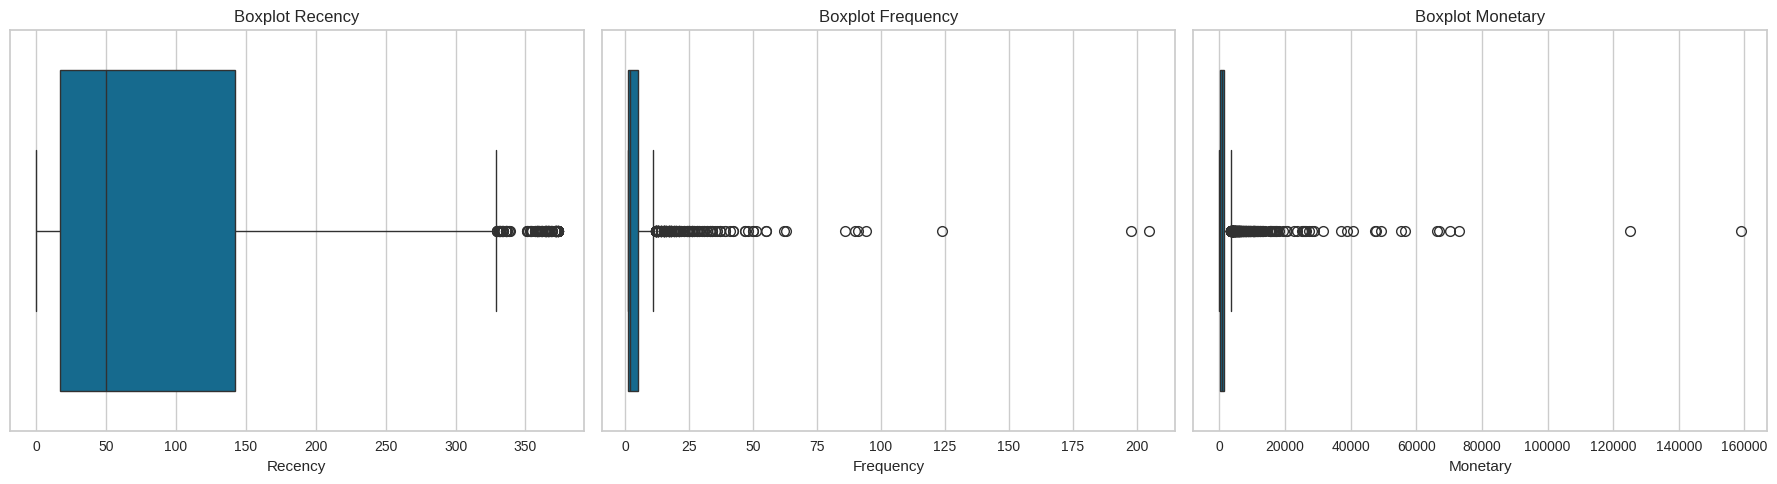

In [240]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=rfm['Recency'])
plt.title('Boxplot Recency')

plt.subplot(1, 3, 2)
sns.boxplot(x=rfm['Frequency'])
plt.title('Boxplot Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(x=rfm['Monetary'])
plt.title('Boxplot Monetary')

plt.tight_layout()
plt.show()

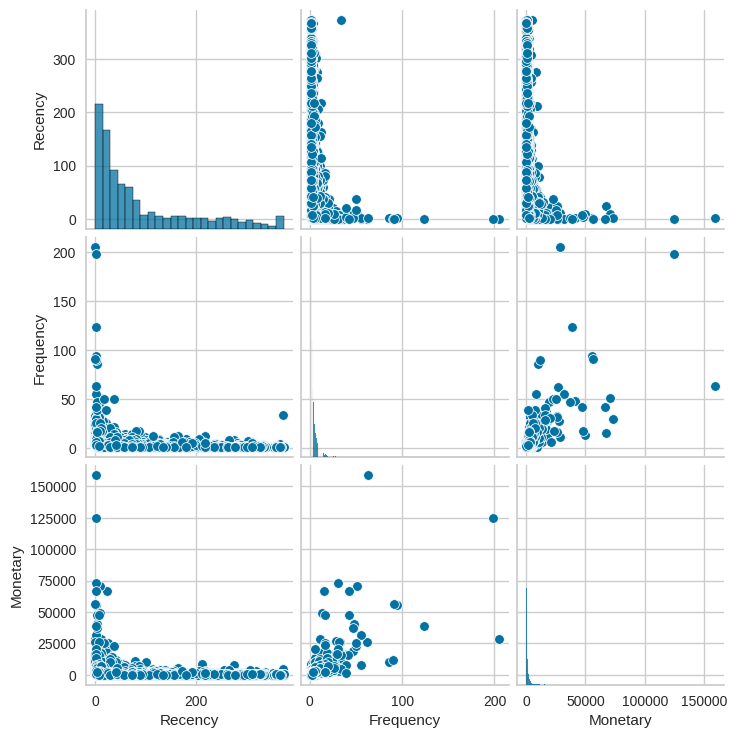

In [241]:
sns.pairplot(rfm)
plt.show()

# **PREPROCESSING**

In [242]:
print("Missing values pada RFM:")
rfm.isna().sum()

Missing values pada RFM:


,0
Recency,0
Frequency,0
Monetary,0


In [243]:
rfm_log = rfm.copy()
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

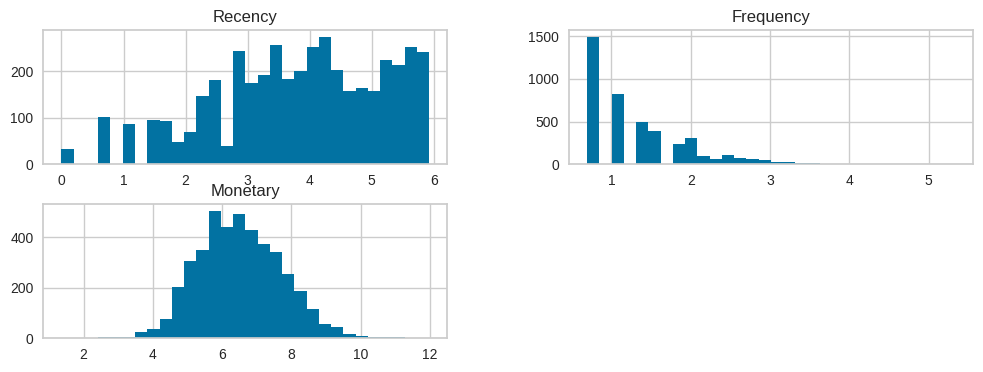

In [244]:
rfm_log[['Recency', 'Frequency', 'Monetary']].hist(bins=30, figsize=(12,4))
plt.show()

In [245]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency','Frequency','Monetary']])

rfm_scaled = pd.DataFrame(rfm_scaled,
                          columns=['Recency','Frequency','Monetary'],
                          index=rfm.index)

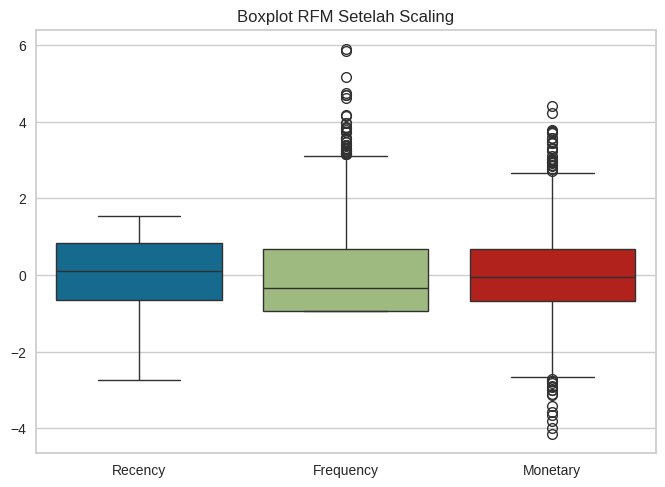

In [246]:
sns.boxplot(data=rfm_scaled)
plt.title("Boxplot RFM Setelah Scaling")
plt.show()

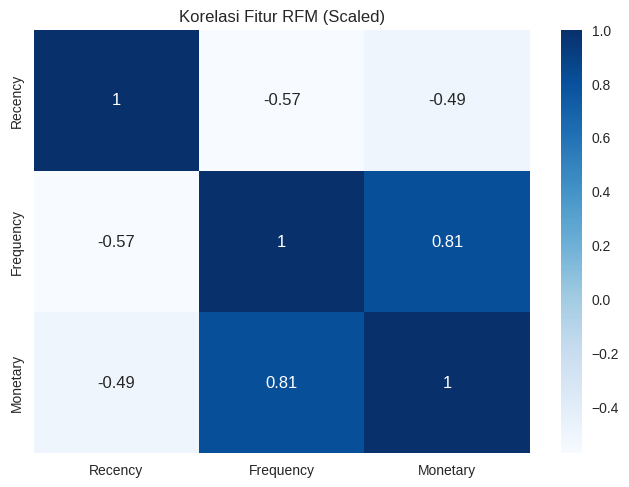

In [247]:
sns.heatmap(rfm_scaled.corr(), annot=True, cmap="Blues")
plt.title("Korelasi Fitur RFM (Scaled)")
plt.show()

# **ELBOW METHOD**

Jumlah cluster optimal (Elbow): 3


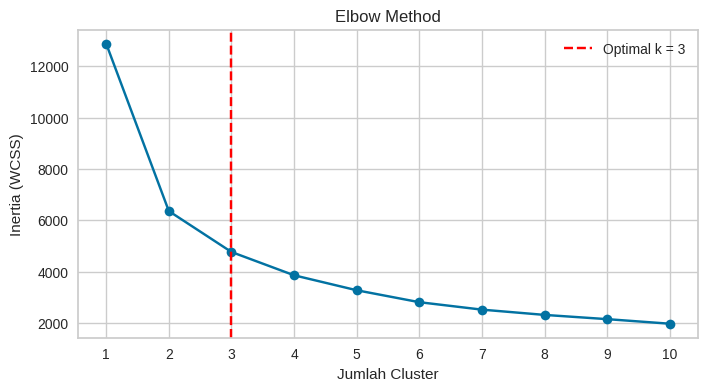

In [248]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

kl = KneeLocator(K, inertia, curve="convex", direction="decreasing")
optimal_k = kl.elbow

print("Jumlah cluster optimal (Elbow):", optimal_k)

plt.figure(figsize=(8,4))
plt.plot(K, inertia, marker='o')
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')

plt.title("Elbow Method")
plt.xlabel("Jumlah Cluster")
plt.ylabel("Inertia (WCSS)")
plt.xticks(K)
plt.grid(True)
plt.legend()
plt.show()

# **K-MEANS**

In [249]:
k_optimal = 3

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

In [250]:
cluster_summary = rfm.groupby('cluster').agg({
    'Recency': ['mean','median'],
    'Frequency': ['mean','median'],
    'Monetary': ['mean','median']
}).round(2)

cluster_summary

Recency        Frequency        Monetary         
           mean median      mean median     mean   median
cluster                                                  
0        162.14  154.0      1.34    1.0   332.37   276.17
1         13.53    8.0     13.28   10.0  5897.92  3477.08
2         45.14   30.0      3.50    3.0  1201.14   961.08

In [251]:
cluster_labels = {
    0: 'At Risk',
    1: 'VIP',
    2: 'Regular',
}

rfm['Cluster'] = rfm['cluster'].map(cluster_labels)

In [252]:
rfm['Cluster'].value_counts().sort_index()

,count
Cluster,
At Risk,1918
Regular,1646
VIP,726


In [253]:
rfm[['Recency','Frequency','Monetary','Cluster']].head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12347,2,7,4060.40,VIP
12348,75,4,1186.68,Regular
12349,18,1,1353.80,Regular
12350,310,1,294.40,At Risk
12352,36,7,1385.74,Regular


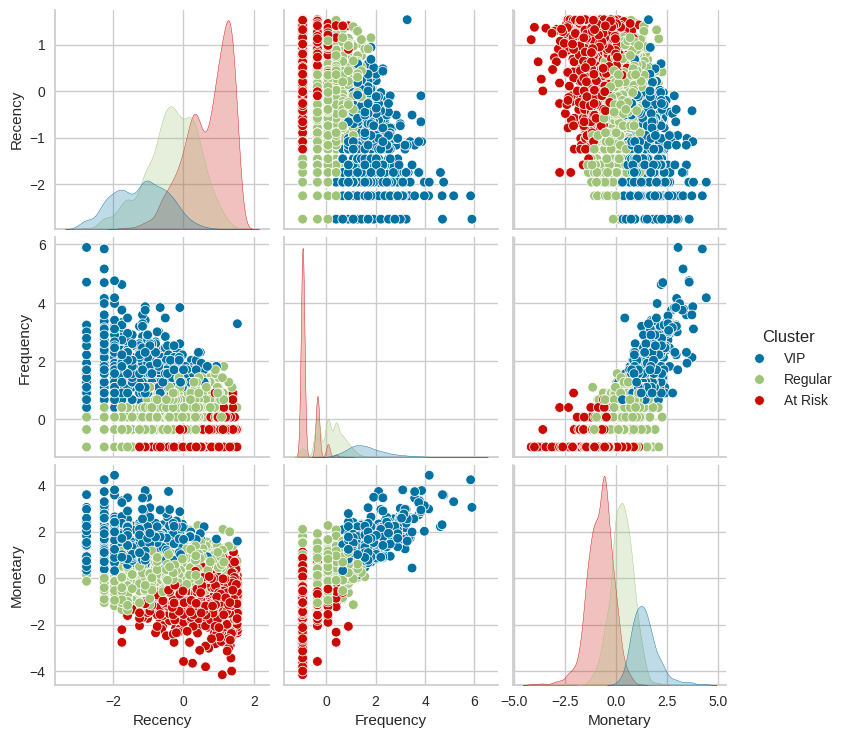

In [254]:
sns.pairplot(rfm_scaled.join(rfm['Cluster']), hue='Cluster')
plt.show()

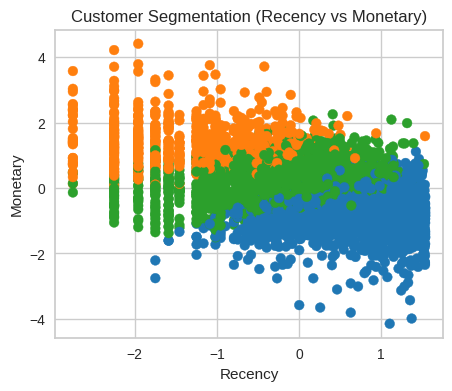

In [255]:
n_cluster = rfm['cluster'].nunique()
palette = sns.color_palette("tab10", n_cluster)

color_map = {i: palette[i] for i in range(n_cluster)}

plt.figure(figsize=(5,4))
plt.scatter(
    rfm_scaled['Recency'],
    rfm_scaled['Monetary'],
    c=rfm['cluster'].map(color_map)
)
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Customer Segmentation (Recency vs Monetary)')
plt.show()


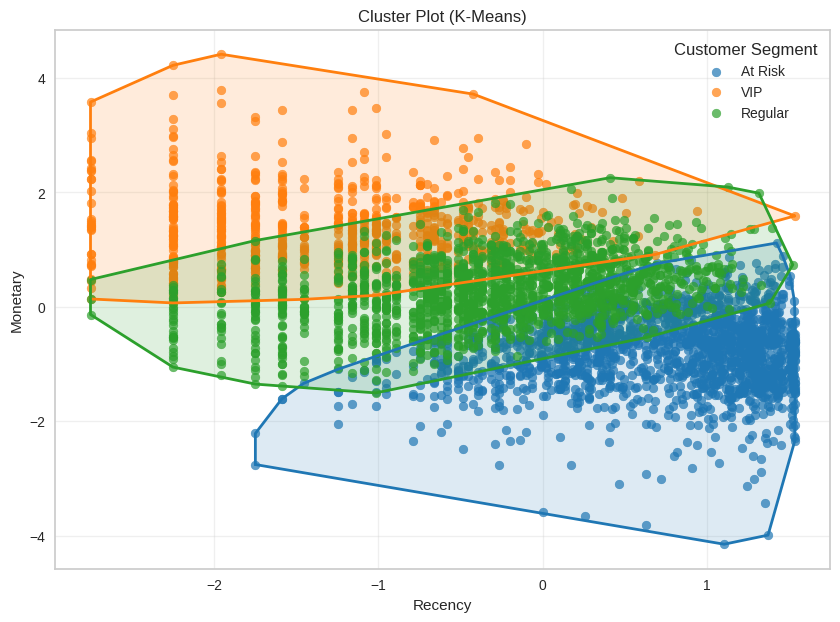

In [256]:
palette = sns.color_palette("tab10", 3)

color_map = {0: palette[0], 1: palette[1], 2: palette[2]}

cluster_names = {
    0: 'At Risk',
    1: 'VIP',
    2: 'Regular'
}

x = rfm_scaled['Recency']
y = rfm_scaled['Monetary']
clusters = rfm['cluster']

plt.figure(figsize=(10, 7))

for cluster_id in sorted(clusters.unique()):

    points = np.column_stack((x[clusters == cluster_id], y[clusters == cluster_id]))

    plt.scatter(points[:, 0], points[:, 1],
                color=color_map[cluster_id],
                label=cluster_names[cluster_id],
                alpha=0.7,
                s=40)

    if len(points) >= 3:
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        hull_points = np.concatenate((hull_points, hull_points[:1]))

        plt.plot(hull_points[:, 0], hull_points[:, 1],
                 color=color_map[cluster_id],
                 linewidth=2)

        plt.fill(hull_points[:, 0], hull_points[:, 1],
                 color=color_map[cluster_id],
                 alpha=0.15)

plt.xlabel("Recency")
plt.ylabel("Monetary")
plt.title("Cluster Plot (K-Means)")
plt.legend(title="Customer Segment")
plt.grid(alpha=0.3)
plt.show()

# **CHURN**

In [257]:
rfm['churn'] = np.where(rfm['Recency'] > 160, 1, 0)
rfm['Churn'] = rfm['churn'].map({1: 'Churned', 0: 'Active'})

In [258]:
rfm['Churn'].value_counts()

,count
Churn,
Active,3319
Churned,971


In [259]:
pd.crosstab(rfm['Cluster'], rfm['Churn'])

Churn,Active,Churned
Cluster,,
At Risk,1003,915
Regular,1592,54
VIP,724,2


In [260]:
rfm[['Recency','Frequency','Monetary','Cluster','Churn']].head()

,Recency,Frequency,Monetary,Cluster,Churn
CustomerID,,,,,
12347,2,7,4060.40,VIP,Active
12348,75,4,1186.68,Regular,Active
12349,18,1,1353.80,Regular,Active
12350,310,1,294.40,At Risk,Churned
12352,36,7,1385.74,Regular,Active


# **TOP BARANG YANG BANYAK DIBELI DAN BARANG YANG JARANG DIBELI**

In [261]:
top_products = df_clean['Description'].value_counts().head(50)

top_products_df = top_products.reset_index()
top_products_df.columns = ['Product', 'Total Sold']

top_products_df

,Product,Total Sold
0,WHITE HANGING HEART T-LIGHT HOLDER,1979
1,REGENCY CAKESTAND 3 TIER,1696
2,JUMBO BAG RED RETROSPOT,1557
3,PARTY BUNTING,1377
4,ASSORTED COLOUR BIRD ORNAMENT,1342
5,LUNCH BAG RED RETROSPOT,1299
6,SET OF 3 CAKE TINS PANTRY DESIGN,1147
7,LUNCH BAG BLACK SKULL.,1077
8,PACK OF 72 RETROSPOT CAKE CASES,1029
9,SPOTTY BUNTING,1007


In [262]:
rare_products = df_clean['Description'].value_counts().tail(50)

rare_products_df = rare_products.reset_index()
rare_products_df.columns = ['Product', 'Total Sold']

rare_products_df

,Product,Total Sold
0,BELL HEART ANTIQUE GOLD,1
1,PINK EASTER HENS+FLOWER,1
2,MARIE ANTOIENETT TRINKET BOX GOLD,1
3,RED ROSE AND LACE C/COVER,1
4,TEA TIME BREAKFAST BASKET,1
5,ROBIN CHRISTMAS CARD,1
6,BEADED LOVE HEART JEWELLERY SET,1
7,PINK BAROQUE FLOCK CANDLE HOLDER,1
8,BAROQUE BUTTERFLY EARRINGS CRYSTAL,1
9,POLYESTER FILLER PAD 60x40cm,1


In [263]:
df_clean['Description'].value_counts().value_counts()

,count
count,
1,211
2,155
3,131
5,84
4,78
...,...
1342,1
1377,1
1557,1


# **DOWNLOAD DATA**

In [264]:
df_final = df_clean.merge(rfm, on='CustomerID', how='left')

In [265]:
df_final.to_excel('dataset_final_clustering_churn.xlsx', index=False)
files.download('dataset_final_clustering_churn.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [266]:
top_products_df.to_excel('top_products.xlsx', index=False)
files.download('top_products.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [267]:
rare_products_df.to_excel('rare_products.xlsx', index=False)
files.download('rare_products.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [268]:
%%writefile /content/README.md

# SegmaX: Smart Customer Segmentation System

## Deskripsi Proyek
Proyek ini bertujuan untuk menganalisis perilaku pelanggan menggunakan metode
**RFM (Recency, Frequency, Monetary)** dan **clustering K-Means**.

Hasil analisis digunakan untuk mengelompokkan pelanggan ke dalam beberapa segmen
(seperti **VIP**, **Regular**, dan **At Risk**) guna mendukung pengambilan keputusan
dan penyusunan strategi marketing yang lebih efektif.

Proyek dikembangkan menggunakan **Python** dan dijalankan melalui
**Google Colab**.

---

## Setup Environment (Google Colab)

1. Buka Google Colab melalui:
   https://colab.research.google.com/
2. Upload atau buka notebook proyek (`.ipynb`).
3. Upload dataset ke Colab atau hubungkan dengan Google Drive.
4. Install dependensi:
   pip install -r requirements.txt
5. Jalankan code

Overwriting /content/README.md


In [269]:
%%writefile /content/.gitignore
__pycache__/
.ipynb_checkpoints/
.env
*.pkl
*.joblib

Overwriting /content/.gitignore


In [270]:
%%writefile .env.example
Project ini tidak menggunakan environment variable

Overwriting .env.example


In [271]:
!pip freeze > /content/requirements.txt

# **DASHBOARD LOOKER STUDIO**
[Klik di sini untuk membuka Dashboard Looker Studio](https://lookerstudio.google.com/reporting/739d962b-a8dc-4009-99ab-6d6c66983bd0)
